In [1]:

from outputmethods import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, precision_score,roc_auc_score


In [2]:
#pre-defined functions
def CreateDecileAnalysis(d, numBins):
    # deciles is a dataframe with the following columns:
    # [PROB, PRED, TARG]
    d = d.copy()
    d['PROB_MIN'] = d['PROB']
    d['PROB_MAX'] = d['PROB']
    d.rename(columns={'PROB': 'PROB_AVG'}, inplace=True)
    d['RECS'] = 1
    d['BINS'] = pd.qcut(d['PROB_MIN'].rank(method = 'first'), numBins, labels=False, duplicates='drop')

    d = d.groupby('BINS', as_index=False).agg(
        {'PROB_MIN': np.min, 'PROB_AVG': np.mean, 'PROB_MAX': np.max,  'TARGET': np.sum, 'RECS': np.sum})
    
    d['PROB_MIN'] = d['PROB_MIN'].round(15)
    d['PROB_AVG'] = d['PROB_AVG'].round(15)
    d['PROB_MAX'] = d['PROB_MAX'].round(15)

    d = d.reindex(columns=['BINS', 'PROB_AVG', 
                           'TARGET',
                           'RECS', 'PROB_MIN', 'PROB_MAX'])
    d = d.sort_values('BINS', ascending=False)
    d['BINS'] = d['BINS'].astype(str)
    # Output: Deciles
    return d

def CreateROCcurve(results):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(results['TARGET'], results['PROB'])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.figure(2, figsize=(10, 10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def read_data(path):
    """
    Read the data into pandas dataframe
    """
    data = pd.read_csv(path,encoding = 'iso-8859-1')
    return data

def get_headers(dataset): 
    return dataset.columns.values

In [3]:
INPUT_PATH = 'C:/Users/SamarDeen/Desktop/NewCoStreams/DataV2/m2exist_train.csv'
INPUT_PATH_TEST = 'C:/Users/SamarDeen/Desktop/NewCoStreams/DataV2/m2exist_test.csv' 

In [4]:
m2e_train = read_data(INPUT_PATH)
m2e_test = read_data(INPUT_PATH_TEST)

In [5]:
for c in (m2e_train.columns):
    print(c)

ACTIVITY_NUMBER
REGISTRATION_ID
SOURCE_DESCRIPTION
BUS_AREA_GRP_1
BUYERS_JOURNEY_GRP_1
BUYERS_JOURNEY_GRP_2
CHANNEL_NAME_GRP_4
CHANNEL_TYPE_GRP_4
DTL_REVN_COMP_SUM_F4
FIRMO_GBL_EMP_CNT
FIRMO_GBL_TURN_OVER_USD
IBM_GBL_IMT_GRP_3
INCT_CNT
INCT_COMP_F1
INCT_COMP_F10
INCT_COMP_F3
INCT_INDIV_F14
INCT_INDIV_F15
INCT_INDIV_F5
INCT_INDIV_F6
INCT_INDIV_F7
INDUSTRY_GRP_3
INRT_FLG_COMP_F1
INRT_FLG_COMP_F2
INRT_FLG_INDIV_F1
JOB_FUNCTION_GRP_1
JOB_FUNCTION_GRP_3
JOB_LVL_CD_GRP_1
LEAD_COMP_SUM_F8
LEAD_INDIV_SUM_F1
MAIN_COVERAGE_TYPE_GRP_1
MAIN_COVERAGE_TYPE_GRP_2
MARKET_INTERACTION_GRP_3
NLU_KEYWRD_F2
NLU_SCORE_F1
PAGE_VW
PAGE_VW_PER_V
PARENT_ASSET_TYPE_GRP_1
SOURCE_DESCRIPTION_GRP_1
SOURCE_DESCRIPTION_GRP_3
BUS_AREA_NAME
OPTY_NUM
OPP_DTL_KEY
DTL_CREATE_DT
DAYS_DIFF
OPTY
OUTCOME
TARGET
Partition


In [7]:
train_features = m2e_train[['BUS_AREA_GRP_1',
'BUYERS_JOURNEY_GRP_1',
'BUYERS_JOURNEY_GRP_2',
'CHANNEL_NAME_GRP_4',
'CHANNEL_TYPE_GRP_4',
'DTL_REVN_COMP_SUM_F4',
'FIRMO_GBL_EMP_CNT',
'FIRMO_GBL_TURN_OVER_USD',
'IBM_GBL_IMT_GRP_3',
'INCT_CNT',
'INCT_COMP_F1',
'INCT_COMP_F10',
'INCT_COMP_F3',
'INCT_INDIV_F14',
'INCT_INDIV_F15',
'INCT_INDIV_F5',
'INCT_INDIV_F6',
'INCT_INDIV_F7',
'INDUSTRY_GRP_3',
'INRT_FLG_COMP_F1',
'INRT_FLG_COMP_F2',
'INRT_FLG_INDIV_F1',
'JOB_FUNCTION_GRP_1',
'JOB_FUNCTION_GRP_3',
'JOB_LVL_CD_GRP_1',
'LEAD_COMP_SUM_F8',
'LEAD_INDIV_SUM_F1',
'MAIN_COVERAGE_TYPE_GRP_1',
'MAIN_COVERAGE_TYPE_GRP_2',
'MARKET_INTERACTION_GRP_3',
'NLU_KEYWRD_F2',
'NLU_SCORE_F1',
'PAGE_VW',
'PAGE_VW_PER_V',
'PARENT_ASSET_TYPE_GRP_1',
'SOURCE_DESCRIPTION_GRP_1',
'SOURCE_DESCRIPTION_GRP_3']]

test_features = m2e_test[['BUS_AREA_GRP_1',
'BUYERS_JOURNEY_GRP_1',
'BUYERS_JOURNEY_GRP_2',
'CHANNEL_NAME_GRP_4',
'CHANNEL_TYPE_GRP_4',
'DTL_REVN_COMP_SUM_F4',
'FIRMO_GBL_EMP_CNT',
'FIRMO_GBL_TURN_OVER_USD',
'IBM_GBL_IMT_GRP_3',
'INCT_CNT',
'INCT_COMP_F1',
'INCT_COMP_F10',
'INCT_COMP_F3',
'INCT_INDIV_F14',
'INCT_INDIV_F15',
'INCT_INDIV_F5',
'INCT_INDIV_F6',
'INCT_INDIV_F7',
'INDUSTRY_GRP_3',
'INRT_FLG_COMP_F1',
'INRT_FLG_COMP_F2',
'INRT_FLG_INDIV_F1',
'JOB_FUNCTION_GRP_1',
'JOB_FUNCTION_GRP_3',
'JOB_LVL_CD_GRP_1',
'LEAD_COMP_SUM_F8',
'LEAD_INDIV_SUM_F1',
'MAIN_COVERAGE_TYPE_GRP_1',
'MAIN_COVERAGE_TYPE_GRP_2',
'MARKET_INTERACTION_GRP_3',
'NLU_KEYWRD_F2',
'NLU_SCORE_F1',
'PAGE_VW',
'PAGE_VW_PER_V',
'PARENT_ASSET_TYPE_GRP_1',
'SOURCE_DESCRIPTION_GRP_1',
'SOURCE_DESCRIPTION_GRP_3']]

In [8]:
train_target  = m2e_train['TARGET']
train_target.head()
test_target  = m2e_test['TARGET']
test_target.head()
test_target.describe()

count    54422.000000
mean         0.002977
std          0.054479
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: TARGET, dtype: float64

In [9]:
pd.set_option('display.max_columns', 1000)
#get statistics
train_features.describe()

,BUS_AREA_GRP_1,BUYERS_JOURNEY_GRP_1,BUYERS_JOURNEY_GRP_2,CHANNEL_NAME_GRP_4,CHANNEL_TYPE_GRP_4,DTL_REVN_COMP_SUM_F4,FIRMO_GBL_EMP_CNT,FIRMO_GBL_TURN_OVER_USD,IBM_GBL_IMT_GRP_3,INCT_CNT,INCT_COMP_F1,INCT_COMP_F10,INCT_COMP_F3,INCT_INDIV_F14,INCT_INDIV_F15,INCT_INDIV_F5,INCT_INDIV_F6,INCT_INDIV_F7,INDUSTRY_GRP_3,INRT_FLG_COMP_F1,INRT_FLG_COMP_F2,INRT_FLG_INDIV_F1,JOB_FUNCTION_GRP_1,JOB_FUNCTION_GRP_3,JOB_LVL_CD_GRP_1,LEAD_COMP_SUM_F8,LEAD_INDIV_SUM_F1,MAIN_COVERAGE_TYPE_GRP_1,MAIN_COVERAGE_TYPE_GRP_2,MARKET_INTERACTION_GRP_3,NLU_KEYWRD_F2,NLU_SCORE_F1,PAGE_VW,PAGE_VW_PER_V,PARENT_ASSET_TYPE_GRP_1,SOURCE_DESCRIPTION_GRP_1,SOURCE_DESCRIPTION_GRP_3
count,126387.000000,126387.000000,126387.000000,126387.000000,126387.000000,1.263870e+05,1.263870e+05,1.263870e+05,126387.000000,126387.000000,126387.000000,126387.000000,126387.000000,126387.000000,126387.000000,126387.000000,126387.000000,126387.000000,126387.000000,126387.000000,126387.000000,126387.000000,126387.000000,126387.000000,126387.000000,1.263870e+05,1.263870e+05,126387.000000,126387.000000,126387.000000,126387.000000,126387.000000,126387.000000,126387.000000,126387.000000,126387.000000,126387.000000
mean,0.657963,0.378639,0.611788,0.077611,0.077144,-2.005000e-01,2.536968e+04,7.668491e+09,0.669420,0.126445,-0.054226,0.030796,-0.059830,-0.003286,-0.164174,-0.104285,-0.046441,0.008035,0.278011,-0.998389,-1.518323,-3.328882,0.584403,0.185881,0.567416,-2.165000e-02,-3.429000e-02,0.862146,0.137854,0.666239,-0.309300,-0.544648,-0.965764,-0.980422,0.000340,0.389178,0.610822
std,0.474394,0.485050,0.487345,0.267559,0.266821,1.037508e-13,2.122513e+05,3.286718e+10,0.470424,0.854912,0.117163,0.067795,0.016909,0.196554,0.026742,0.095743,0.150832,0.289477,0.448021,0.262664,1.624510,2.061844,0.492827,0.389013,0.495436,5.925839e-15,2.377274e-14,0.344748,0.344748,0.471557,0.055895,0.145241,0.792886,0.375247,0.018442,0.487566,0.487566
min,0.000000,0.000000,0.000000,0.000000,0.000000,-2.005000e-01,-1.000000e+00,-1.000000e+00,0.000000,0.000000,-0.080602,-0.816497,-0.263944,-3.029614,-0.615093,-2.041789,-0.889665,-0.718714,0.000000,-1.513730,-4.705600,-4.714700,0.000000,0.000000,0.000000,-2.165000e-02,-3.429000e-02,0.000000,0.000000,0.000000,-0.312820,-0.553800,-1.000000,-1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,-2.005000e-01,-1.000000e+00,-1.000000e+00,0.000000,0.000000,-0.077378,0.033015,-0.061239,-0.109000,-0.167993,-0.131045,-0.125000,-0.073486,0.000000,-0.864500,-0.690400,-4.714700,0.000000,0.000000,0.000000,-2.165000e-02,-3.429000e-02,1.000000,0.000000,0.000000,-0.312820,-0.553800,-1.000000,-1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,-2.005000e-01,4.800000e+01,8.490467e+06,1.000000,0.000000,-0.074104,0.037760,-0.059574,-0.109000,-0.152900,-0.070710,-0.125000,-0.058960,0.000000,-0.864500,-0.690400,-4.714700,1.000000,0.000000,1.000000,-2.165000e-02,-3.429000e-02,1.000000,0.000000,1.000000,-0.312820,-0.553800,-1.000000,-1.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,-2.005000e-01,5.000000e+03,1.741370e+09,1.000000,0.000000,-0.063708,0.037887,-0.059002,0.146490,-0.152900,-0.070710,0.118980,-0.058960,1.000000,-0.864500,-0.690400,-0.261300,1.000000,0.000000,1.000000,-2.165000e-02,-3.429000e-02,1.000000,0.000000,1.000000,-0.312820,-0.553800,-1.000000,-1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,-2.005000e-01,6.540000e+06,1.069028e+12,1.000000,32.000000,1.644809,1.551913,0.190265,4.129312,0.116236,2.512090,3.951700,8.309301,1.000000,-0.864500,-0.269100,-0.137100,1.000000,1.000000,1.000000,-2.165000e-02,-3.429000e-02,1.000000,1.000000,1.000000,0.767000,2.090055,57.000000,22.000000,1.000000,1.000000,1.000000


In [10]:
regressor = RandomForestClassifier(n_estimators = 90 , min_samples_split=2, min_samples_leaf = 2,
                                   max_features = 0.13, max_depth= 12, bootstrap = True, 
                                   criterion = 'entropy', random_state = 42)
regressor.fit(train_features, train_target)
cutoff = 0.002977


In [11]:
# Generate confusion matrix for training set
pro_t = regressor.predict_proba(train_features)
proba_t = pd.DataFrame(pro_t, columns = ['0','1'])
proba_t ['prediction'] = np.where(proba_t['1'] >= cutoff, 1, 0)
conf_train = confusion_matrix(train_target, proba_t['prediction'])
TN = conf_train[0,0]
FP = conf_train[0,1]
FN = conf_train[1,0]
TP = conf_train[1,1]

print(TN , FP , TP , FN)
print('True Negative Rate: ', (TN/(TN+FP)).round(3))
print('True Positive Rate: ', (TP/(TP+FN)).round(3))

89366 36660 361 0
True Negative Rate:  0.709
True Positive Rate:  1.0


In [13]:
#subset and choose columns
mod_data = m2e_train[['TARGET']]
mod_data.head()
proba_t.rename(columns={'1': 'PROB'}, inplace=True)
proba_t.rename(columns={'prediction': 'PRED'}, inplace=True)
proba_t.head()
d = pd.concat([proba_t, mod_data],axis=1)
d.head()

,0,PROB,PRED,TARGET
0,1.0,0.0,0,0
1,1.0,0.0,0,0
2,1.0,0.0,0,0
3,1.0,0.0,0,0
4,1.0,0.0,0,0


In [14]:
CreateDecileAnalysis(d, 10)

,BINS,PROB_AVG,TARGET,RECS,PROB_MIN,PROB_MAX
9,9,0.015611,355,12639,0.008812,0.819067
8,8,0.006872,6,12639,0.005169,0.008812
7,7,0.003965,0,12638,0.002837,0.005169
6,6,0.001700,0,12639,0.000422,0.002837
5,5,0.000063,0,12638,0.000000,0.000421
4,4,0.000000,0,12639,0.000000,0.000000
3,3,0.000000,0,12639,0.000000,0.000000
2,2,0.000000,0,12638,0.000000,0.000000
1,1,0.000000,0,12639,0.000000,0.000000
0,0,0.000000,0,12639,0.000000,0.000000


In [15]:
# Area under Curve - ROC Curve
lm_auc = roc_auc_score(d['TARGET'], d['PROB'])
print('\nAUC: ' + str(lm_auc))


AUC: 0.9900761584922041


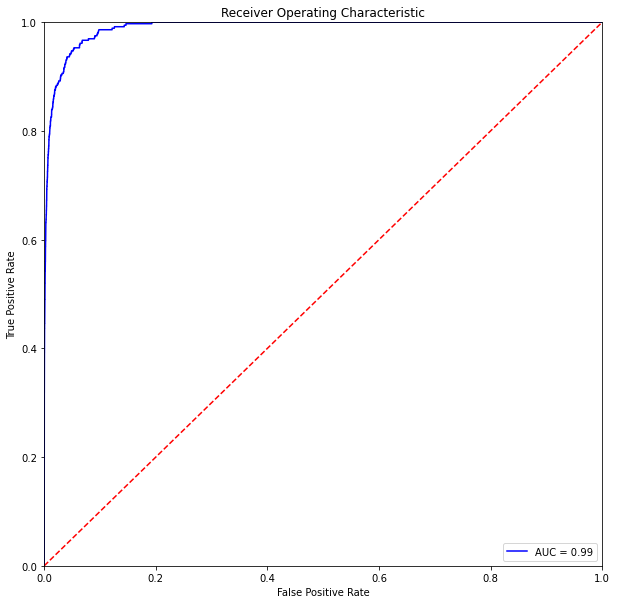

In [16]:
CreateROCcurve(d)

In [17]:
feature_list = list(train_features.columns)
# Get numerical feature importance
importances = list(regressor.feature_importances_)
#List of tuples with variable and importance
feature_importances = [(features, importance) for features,importance in zip(feature_list, importances)]
#Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
#Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]; 

Variable: INCT_INDIV_F15       Importance: 0.07847839959689709
Variable: INCT_INDIV_F14       Importance: 0.0732252021072961
Variable: BUYERS_JOURNEY_GRP_2 Importance: 0.06631613287855792
Variable: INCT_COMP_F10        Importance: 0.0660247349655507
Variable: INCT_INDIV_F6        Importance: 0.06385770700487003
Variable: INCT_COMP_F1         Importance: 0.0638199920123442
Variable: INCT_COMP_F3         Importance: 0.06338678699209847
Variable: INCT_INDIV_F5        Importance: 0.06311308808364875
Variable: INCT_INDIV_F7        Importance: 0.05462370739310763
Variable: FIRMO_GBL_TURN_OVER_USD Importance: 0.047323970893293765
Variable: FIRMO_GBL_EMP_CNT    Importance: 0.041734380681601846
Variable: SOURCE_DESCRIPTION_GRP_1 Importance: 0.04048007955154358
Variable: BUYERS_JOURNEY_GRP_1 Importance: 0.03873688752691529
Variable: SOURCE_DESCRIPTION_GRP_3 Importance: 0.03432420294451494
Variable: JOB_LVL_CD_GRP_1     Importance: 0.03242141514234685
Variable: IBM_GBL_IMT_GRP_3    Importance: 0.

In [18]:
regressor.predict(test_features)
pro = regressor.predict_proba(test_features)
proba = pd.DataFrame(pro, columns = ['0','1'])
proba['prediction'] = np.where(proba['1'] >= cutoff, 1, 0)
conf = confusion_matrix(test_target,proba['prediction']) 
TN = conf[0,0]
FP = conf[0,1]
FN = conf[1,0]
TP = conf[1,1]
print(TN , FP , TP , FN)
print('True Negative Rate: ', (TN/(TN+FP)).round(3))
print('True Positive Rate: ', (TP/(TP+FN)).round(3))


37914 16346 149 13
True Negative Rate:  0.699
True Positive Rate:  0.92


In [20]:
#merge predicted probability of test data with Target
proba.rename(columns={'1': 'PROB'}, inplace=True)
proba.rename(columns={'prediction': 'PRED'}, inplace=True)
proba.head()
test_data = m2e_test[['TARGET']]
d_test = pd.concat([proba, test_data], axis=1)
#d_test.head()
CreateDecileAnalysis(d_test, 10)

,BINS,PROB_AVG,TARGET,RECS,PROB_MIN,PROB_MAX
9,9,0.015262,95,5443,0.009180,0.819067
8,8,0.007154,35,5442,0.005458,0.009180
7,7,0.004210,18,5442,0.003050,0.005457
6,6,0.001919,13,5442,0.000615,0.003050
5,5,0.000096,1,5442,0.000000,0.000615
4,4,0.000000,0,5442,0.000000,0.000000
3,3,0.000000,0,5442,0.000000,0.000000
2,2,0.000000,0,5442,0.000000,0.000000
1,1,0.000000,0,5442,0.000000,0.000000
0,0,0.000000,0,5443,0.000000,0.000000
